Import relevant packages and import custom syntethic data generation class "CameraProjection"

In [64]:
import os
# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

os.chdir("c:/Users\Bruger/Documents/Thesis/Road-Anomaly-Detector/")

# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

c:\Users\Bruger\Documents\Thesis\Road-Anomaly-Detector
c:\Users\Bruger\Documents\Thesis\Road-Anomaly-Detector


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from road_anomaly_detector.main.calibration.Camera_calibration.synthetic_data import CameraProjection
from scipy import interpolate
from scipy.optimize import least_squares

# Calibration

## Pattern

### Functions

In [ ]:
# Step 2 feature point correspondences

def cross_ratio(unit):
    if unit.size != 4 or unit.ndim != 1:
        raise ValueError("Input must be a 1D numpy array with exactly four elements.")
    
    A, B, C, D = unit
    return ((C-A) / (C-B)) / ((D-A) / (D-B))


def feature_points_correspondences(X_image_coordinates, h, l):
    # P D P D P D P

    # Pad last vertical line based on ca = da * 2
    ca_last = X_image_coordinates[-1] - X_image_coordinates[-3]
    X_image_coordinates = np.append(X_image_coordinates, [0, X_image_coordinates[-1] + ca_last])
    
    #Find all diagonal X in pattern coordinates
    i = 1
    diagonal = []
    for i_cross in range(0, len(X_image_coordinates) - 4, 2):  # Move 2 steps forward each iteration
        # Find ABCD according to figure 2 in paper
        ABCD = X_image_coordinates[[i_cross, i_cross+1, i_cross+2, i_cross+4]] # A B C D
        # Cross ratio
        r_abcd = cross_ratio(ABCD)
        eta = (2*r_abcd-2) / (2*r_abcd-1)
        # Find X
        x_b = eta * h + (i-1)*h
        # Find Y
        y_b = (l/h) * x_b - (i-1) * l
        # Next diagonal line
        i = i + 1
        #append
        diagonal.append([x_b, y_b])

    #Find all other lines
    #print(diagonal)
    diagonal = np.array(diagonal) 
    vertical = []
    for i in range(0, len(diagonal), 2):
        x_a = i*h
        if i != 0:
            x_c = (i+1)*h
        else:
            x_c = 1*h

        # Extract coordinates from diagonals
        if i != len(diagonal)-1:
            dia_points = diagonal[[i,i+1]]
        else:
            dia_points = diagonal[[i-1, i]]

        x1, y1 = dia_points[0]
        x2, y2 = dia_points[1]
        # Calculate slope (m)
        m = (y2 - y1) / (x2 - x1)
        # Calculate y-intercept (b)
        b = y1 - m * x1
        # Calculate y
        y_a = m * x_a + b
        y_c = m * x_c + b
        # append
        vertical.append([x_a,y_a])
        vertical.append([x_c, y_c])

    vertical = np.array(vertical)
    # Create an empty array for interlaced coordinates
    pattern_coordinates = np.empty((diagonal.shape[0] + vertical.shape[0], 2), dtype=diagonal.dtype)

    # Interlace arrays
    pattern_coordinates[0::2] = vertical  # Place `vertical` elements at even rows
    pattern_coordinates[1::2] = diagonal  # Place `diagonal` elements at odd rows
    #print(diagonal.shape)
    #print(vertical.shape)
    return pattern_coordinates

def project_feature_points_1d_to_2d(points_1d, u):
    """
    Projects 1D feature points onto a 2D space by rotating 90 degrees around an estimated optical center.
    ASSUMING FIRST PART OF ARRAY IS POINTS AND NEXT PART IS PROJECTION
    """
    # Start by finding points
    Y = np.ones(np.size(points_1d)) * u
    points_2d = np.vstack((points_1d, Y)).T

    # Find projection
    rotation_matrix = np.array([[0, -1], [1, 0]])
    points_2d_projection = []

    for point in points_1d:
        # Map 1D points to 2D by duplicating the contrast
        point_2d_projection = rotation_matrix @ (np.array([point, u]) - np.array([u, u])) + np.array([u, u])
        points_2d_projection.append(point_2d_projection)
    
    

    return np.vstack((points_2d,points_2d_projection))

def find_optical_pattern(image_coords, pattern_coords, u):
    low_index = np.searchsorted(image_coords,u)

    Pattern_low = pattern_coords[low_index-1]
    Pattern_high = pattern_coords[low_index]

    dist_u_image = u - image_coords[low_index-1]
    dist_image = image_coords[low_index] - image_coords[low_index-1]
    dist_pattern = Pattern_high[0] - Pattern_low[0]

    Pattern_to_Image = dist_pattern/dist_image
    dist_u_pattern = Pattern_to_Image * dist_u_image

    x_a = Pattern_low[0]+dist_u_pattern
    x1, y1 = Pattern_low
    x2, y2 = Pattern_high
    # Calculate slope (m)
    m = (y2 - y1) / (x2 - x1)
    # Calculate y-intercept (b)
    b = y1 - m * x1
    # Calculate y
    y_a = m * x_a + b

    return np.array([x_a, y_a])

def project_pattern_points(image_coords, pattern_coords, optical_center):
    #find optical pattern
    pattern_optical = find_optical_pattern(image_coords, pattern_coords, optical_center)
    
    #rotate
    rotation_matrix = np.array([
        [0, -1],
        [1, 0]
    ])

    translated_points = pattern_coords - pattern_optical
    rotated_translated_points = translated_points @ rotation_matrix.T
    rotated_pattern_coords = rotated_translated_points + pattern_optical

    return np.vstack((pattern_coords,rotated_pattern_coords))


### calculate 

In [67]:
syntheticData = False
if syntheticData == True:
    #Generate data
    fx = 1260  # Focal length in x (pixels)
    fy = 1260  # Focal length in y (pixels)
    u0 = 1020  # Principal point x-coordinate (pixels)
    v0 = 1020  # Principal point y-coordinate (pixels)
    img_width = 2048  # Image width (pixels)
    img_height = 2048  # Image height (pixels)

    h = 60
    l = 20

    rx_deg = 0    # Rotation around x-axis
    ry_deg = 0   # Rotation around y-axis
    rz_deg = 0    # Rotation around z-axis

    t1 = np.array([0, 0, 1800])  # Translation vector (mm)
    t2 = np.array([0, 0, 2000])  # Translation vector (mm)

    # Instantiate the class
    camera_projection_0 = CameraProjection(fx, fy, u0, v0, img_width, img_height, rx_deg, ry_deg, rz_deg, t1)
    camera_projection_5 = CameraProjection(fx, fy, u0, v0, img_width, img_height, rx_deg, ry_deg, 5, t2)

    # Project points and plot
    u_valid_0, v_valid_0 = camera_projection_0.project_points(0.1, point_distance=h,num_points=41)
    u_valid_5, v_valid_5 = camera_projection_5.project_points(0.1, point_distance=h,num_points=41)
    camera_projection_0.plot_points(u_valid_0, v_valid_0)
    camera_projection_5.plot_points(u_valid_5, v_valid_5)

else:
    from road_anomaly_detector.main.calibration.Camera_calibration.find_image_coords import *

    h = 0.025
    l = 0.200


    image_0 = cv2.imread('road_anomaly_detector/main/calibration/Camera_calibration/calibration_image_0.png', cv2.IMREAD_GRAYSCALE)
    image_5 = cv2.imread('road_anomaly_detector/main/calibration/Camera_calibration/calibration_image_5.png', cv2.IMREAD_GRAYSCALE)
    
    # plt.figure()
    # plt.title("Detected Lines with Subpixel Centers")
    # plt.imshow(image_0)
    # plt.show()

    u_valid_0 = find_line_x(image_0,200)
    u_valid_5 = find_line_x(image_5,200)

    #plot_cross_dot(image_0,u_valid_0)
    #plot_cross_dot(image_5,u_valid_5)


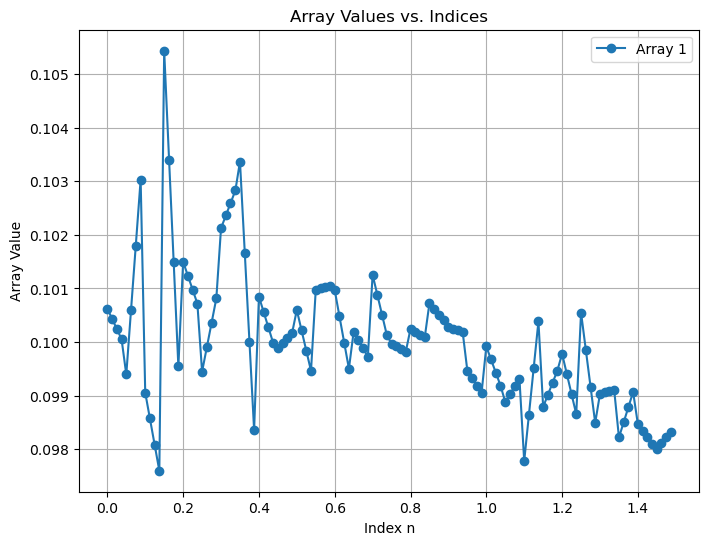

(120, 2)
(120,)
(120, 2)
(120,)
2


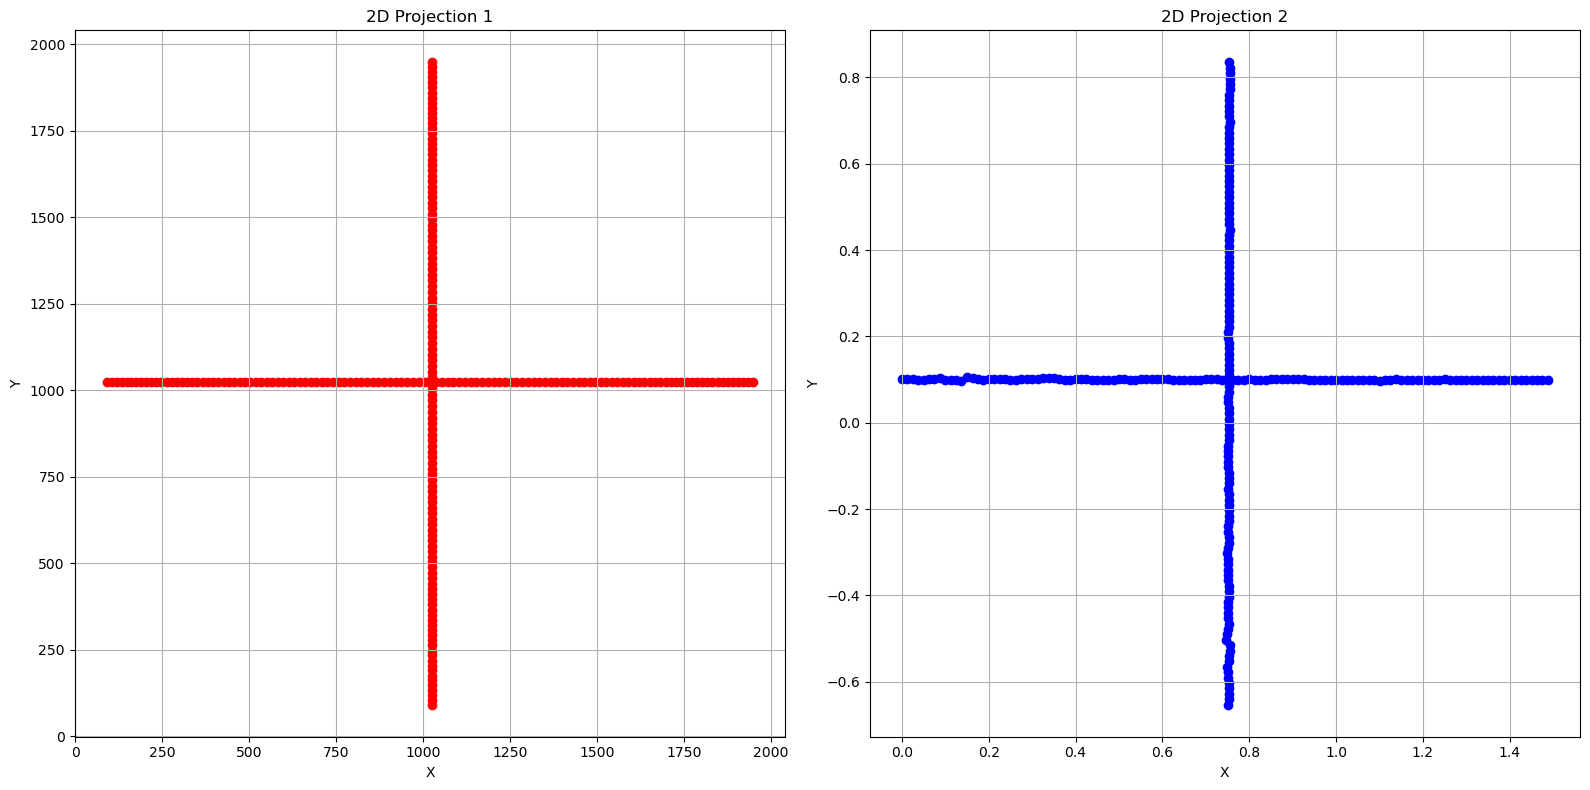

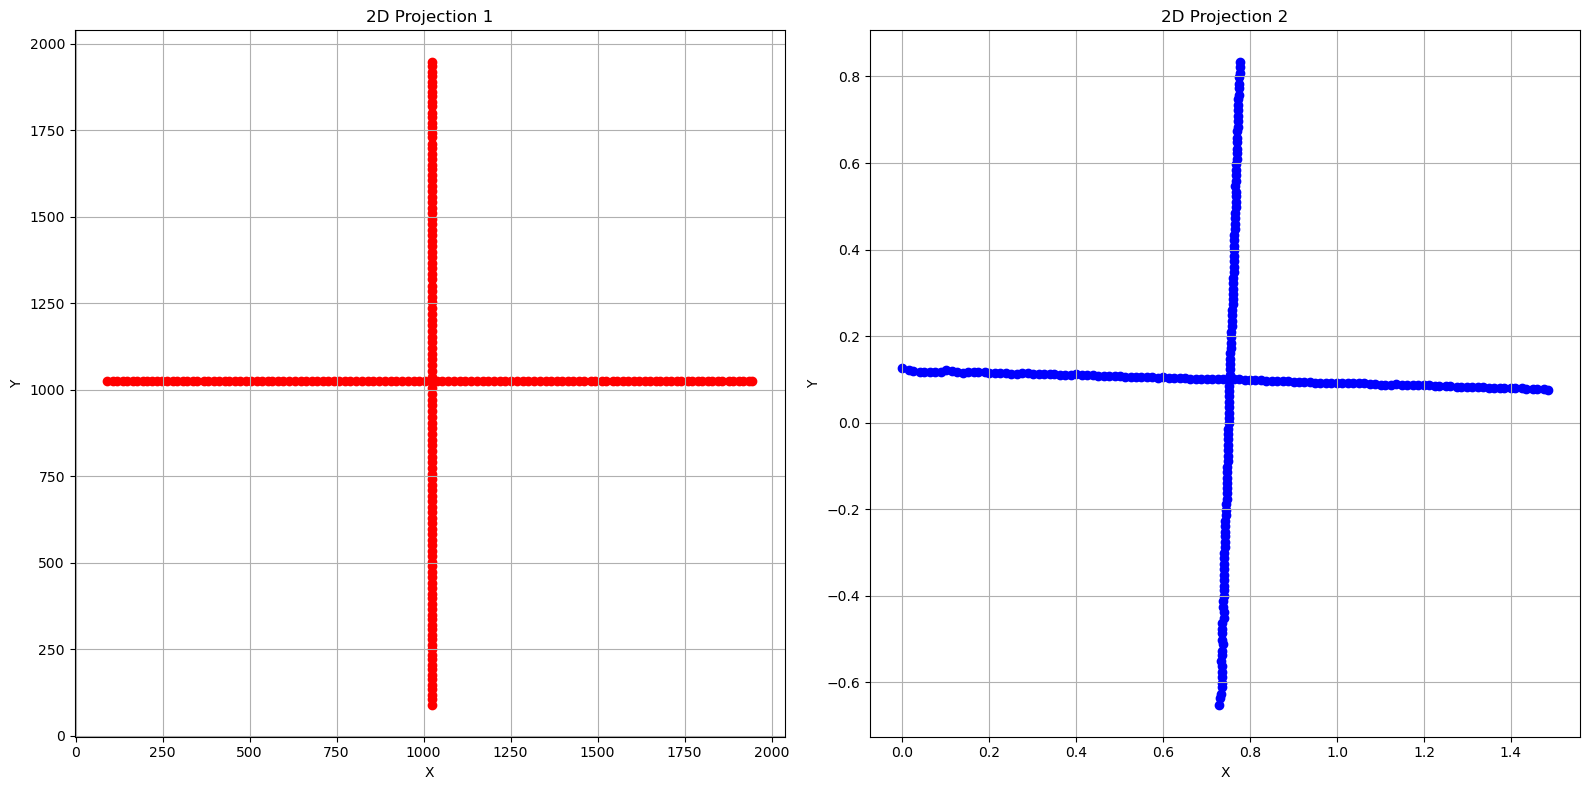

Image 1 - Coordinates:
Image_X	Image_Y	Pattern_X	Pattern_Y
---------------------------------------
90.97	1024.00	0.00	0.10
105.03	1024.00	0.01	0.10
118.97	1024.00	0.03	0.10
132.97	1024.00	0.04	0.10
146.97	1024.00	0.05	0.10
160.97	1024.00	0.06	0.10
175.03	1024.00	0.08	0.10
189.97	1024.00	0.09	0.10
204.03	1024.00	0.10	0.10
218.32	1024.00	0.11	0.10
233.03	1024.00	0.12	0.10
247.18	1024.00	0.14	0.10
262.03	1024.00	0.15	0.11
276.91	1024.00	0.16	0.10
291.03	1024.00	0.18	0.10
305.97	1024.00	0.19	0.10
320.97	1024.00	0.20	0.10
335.89	1024.00	0.21	0.10
350.61	1024.00	0.23	0.10
365.89	1024.00	0.24	0.10
380.91	1024.00	0.25	0.10
395.97	1024.00	0.26	0.10
411.03	1024.00	0.28	0.10
426.03	1024.00	0.29	0.10
441.03	1024.00	0.30	0.10
456.89	1024.00	0.31	0.10
472.03	1024.00	0.33	0.10
487.97	1024.00	0.34	0.10
503.09	1024.00	0.35	0.10
518.97	1024.00	0.36	0.10
534.39	1024.00	0.38	0.10
549.97	1024.00	0.39	0.10
565.96	1024.00	0.40	0.10
581.54	1024.00	0.41	0.10
597.11	1024.00	0.43	0.10
613.03	1024.00	0.44	0.10
62

In [68]:
def plot_2d_projections(points_2d_1, points_2d_2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the first set of points
    axes[0].scatter(points_2d_1[:, 0], points_2d_1[:, 1], color='red', marker='o')
    axes[0].set_title("2D Projection 1")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].grid(True)
    
    # Plot the second set of points
    axes[1].scatter(points_2d_2[:, 0], points_2d_2[:, 1], color='blue', marker='o')
    axes[1].set_title("2D Projection 2")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_array(array1, array2=None):
    """
    Plots one or two arrays against their indices.

    Parameters:
    array1 (list or np.array): The first array to plot.
    array2 (list or np.array, optional): The second array to plot.
    """
    
    plt.figure(figsize=(8, 6))
    
    if array1 is not None:
        plt.plot(array1[:,0], array1[:,1], marker='o', linestyle='-', label='Array 1')
    
    if array2 is not None:
        n2 = np.zeros(len(array2))
        plt.plot(array2, n2, marker='s', linestyle='--', label='Array 2')
    
    plt.xlabel('Index n')
    plt.ylabel('Array Value')
    plt.title('Array Values vs. Indices')
    plt.legend()
    plt.grid(True)
    plt.show()

images_Xaxis = [u_valid_0, u_valid_5] # Get X data from images (WE CANNOT USE Y IN REAL EXAMPLE)
u_init = 2048/2 # Set the guess of the optical center 

pattern_coordinates_test = feature_points_correspondences(np.array(images_Xaxis[0]),h,l) # Find world coordinates!
plot_array(pattern_coordinates_test)

image_2d = [] 
pattern_2d = []


for u_valid in images_Xaxis:
    pattern_coordinates = feature_points_correspondences(np.array(u_valid),h,l) # Find world coordinates!
    u_valid = u_valid[:pattern_coordinates.shape[0]]
    print(pattern_coordinates.shape)
    print(np.array(u_valid).shape)

    image_2d_temp = project_feature_points_1d_to_2d(u_valid, u_init) # Make the 1D image points into a 2D with the optical center as the middle
    pattern_2d_temp = project_pattern_points(u_valid, pattern_coordinates, u_init) # Make the 1D world coordnates into 2D with the optical center projected and as the middle

    

    #plot_2d_projection(image_2d)
    #plot_2d_projection(pattern_2d)
    image_2d.append(image_2d_temp)
    pattern_2d.append(pattern_2d_temp)

print(len(image_2d))


plot_2d_projections(image_2d[0],pattern_2d[0])
plot_2d_projections(image_2d[1],pattern_2d[1])


for idx, (image_points, pattern_points) in enumerate(zip(image_2d, pattern_2d)):
    print(f"Image {idx + 1} - Coordinates:")
    print("Image_X\tImage_Y\tPattern_X\tPattern_Y")
    print("---------------------------------------")
    for (img_x, img_y), (pat_x, pat_y) in zip(image_points, pattern_points):
        print(f"{img_x:.2f}\t{img_y:.2f}\t{pat_x:.2f}\t{pat_y:.2f}")
    print("\n")

## Closed form

### Functions

In [69]:
def calibrate_from_homographies(H_list):
    # Prepare the matrix V from homographies
    V = []

    for H in H_list:
        #H = H / H[2, 2]  # Normalize H to make H[2,2] = 1
        h1 = H[:, 0]
        h2 = H[:, 1]
        #h3 = H[:, 2]

        # Compute v_12^T * b = 0
        v12 = np.array([
            h1[0]*h2[0] + h1[1]*h2[1],
            (h1[0]+h1[1])*h2[2] + (h2[0]+h2[1])*h1[2],
            h1[2]*h2[2]
        ])

        # Compute (v_11 - v_22)^T * b = 0
        v11 = np.array([
            h1[0]*h1[0] + h1[1]*h1[1],
            2*(h1[0]+h1[1])*h1[2],
            h1[2]*h1[2]
        ])
        v22 = np.array([
            h2[0]*h2[0] + h2[1]*h2[1],
            2*(h2[0]+h2[1])*h2[2],
            h2[2]*h2[2]
        ])
        v_diff = v11 - v22

        V.append(v12)
        V.append(v_diff)

    V = np.array(V)

    # Solve Vb = 0 using SVD
    U, S, VT = np.linalg.svd(V)
    b = VT[-1, :]  # Solution is the last row of V^T corresponding to smallest singular value
    print(b)
    # Extract intrinsic parameters from b
    B11 = b[0]
    B13 = b[1]
    B33 = b[2]

    # Compute intrinsic parameters
    lambda0 = B33 - (2*B13**2 / B11)
    
    fx = np.sqrt(abs(lambda0 / B11))
    u0 = abs(-((B13 * fx**2) / lambda0))
    fy = fx  # Since fx = fy
    v0 = u0  # Since u0 = v0
    k = 0    # Skew is zero

    # Construct the intrinsic matrix M
    M = np.array([
        [fx, k,  u0],
        [0,  fy, v0],
        [0,  0,  1]
    ])

    # Compute extrinsic parameters for each homography
    extrinsics = []
    for H in H_list:
        H = H / H[2, 2]  # Normalize H
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute lambda (scale factor)
        inv_M = np.linalg.inv(M)
        lambda_ = 1 / np.linalg.norm(np.dot(inv_M, h2), 2)

        # Compute rotation vectors
        r1 = lambda_ * np.dot(inv_M, h1)
        r2 = lambda_* np.dot(inv_M, h2) 
        r3 = np.cross(r1, r2)  # Orthogonalize r3 using cross product

        # Ensure orthonormality of rotation matrix using SVD
        R = np.column_stack((r1, r2, r3))
        U_R, _, Vt_R = np.linalg.svd(R)
        R = np.dot(U_R, Vt_R)  # Final orthonormal rotation matrix

        # Convert rotation matrix to Rodrigues rotation vector
        rvec, _ = cv2.Rodrigues(R)

        # Compute translation vector
        t = lambda_ * np.dot(inv_M, h3)

        # Assemble RT matrix
        RT = np.column_stack((R, t))
        #extrinsics.append(RT)

        # Store extrinsics as a dictionary or matrix
        extrinsics.append({
            "rotation_vector": rvec,
            "translation_vector": t
        })
    # Calibrate the camera

    return M, extrinsics

In [70]:
def getH(set1, set2):
    nrows = set1.shape[0]
    if (nrows < 4):
        print("Need atleast four points to compute SVD.")
        return 0

    x = set1[:, 0]
    y = set1[:, 1]
    xp = set2[:, 0]
    yp = set2[:,1]
    A = []
    for i in range(nrows):
        row1 = np.array([x[i], y[i], 1, 0, 0, 0, -x[i]*xp[i], -y[i]*xp[i], -xp[i]])
        A.append(row1)
        row2 = np.array([0, 0, 0, x[i], y[i], 1, -x[i]*yp[i], -y[i]*yp[i], -yp[i]])
        A.append(row2)

    A = np.array(A)
    U, E, V = np.linalg.svd(A, full_matrices=True)
    H = V[-1, :].reshape((3, 3))
    H = H / H[2,2]
    return H

### Caculate

In [98]:
h1, mask  = cv2.findHomography(pattern_2d[0], image_2d[0], cv2.RANSAC, 2.0) # Find homographyes with CV2
h2, mask = cv2.findHomography(pattern_2d[1], image_2d[1], cv2.RANSAC, 2.0)

#h1 = getH(pattern_2d[0],image_2d[0])
#h2 = getH(pattern_2d[1],image_2d[1])

# Make a list of them
H_list = [h1, h2]


np.set_printoptions(suppress=True)
M, extrinsics = calibrate_from_homographies(H_list) # Find closed form solution !!NOT WORKING!!
#calibrate_from_homographies_LMA(H_list) # Find closed form solution WITH LMA !!NOT WORKING!!

print("Intrinsic Matrix M:")
print(M)
print("Extrinsics Matrix M:")
print(extrinsics[0])



[ 0.00000026 -0.00027961  0.99999996]
Intrinsic Matrix M:
[[1236.67307047    0.         1080.4874826 ]
 [   0.         1236.67307047 1080.4874826 ]
 [   0.            0.            1.        ]]
Extrinsics Matrix M:
{'rotation_vector': array([[ 0.08328933],
       [-0.09008475],
       [ 0.00128895]]), 'translation_vector': array([-0.79574193, -0.13886521,  0.84234329])}


## Nonlinear

### Functions

In [112]:
def nonlinear_optimization(object_points_list, image_points_list, initial_params):
    n_images = len(object_points_list)
    
    fx = initial_params['fx']
    u0 = initial_params['u0']
    k1 = initial_params['k1']
    k2 = initial_params['k2']
    k3 = initial_params.get('k3', 0.0) 
    
    rvecs = initial_params['rvecs']  # List of rotation vectors
    tvecs = initial_params['tvecs']  # List of translation vectors
    
    params = [fx, u0, k1, k2, k3] 

    for rvec, tvec in zip(rvecs, tvecs):
        params.extend(np.ravel(rvec))  # Ensure rvec is a 1D array
        params.extend(np.ravel(tvec))  # Ensure tvec is a 1D array

    params = np.array(params, dtype=np.float64)
    #print(params)
    
    def residuals(params, object_points_list, image_points_list):
        fx, u0, k1, k2, k3 = params[0:5]  # Extracted k3
        residuals = []
        idx = 5  # Start index for extrinsic parameters (updated due to k3)
        for i in range(n_images):
            rvec = params[idx:idx+3]
            tvec = params[idx+3:idx+6]
            idx += 6
            object_points = object_points_list[i]
            image_points = image_points_list[i]
            projected_points = project_points(object_points, rvec, tvec, fx, u0, k1, k2, k3)  # Passed k3
            #visualize_projections(image_points, projected_points)
            
            res = (image_points - projected_points).ravel()
            reprojection_error = np.sqrt(np.mean(np.sum((image_points - projected_points)**2, axis=1)))
            #print(f"i={i}, Fx = {fx:.2f}, u0 = {u0:.2f}, k1 = {k1:.2f}, k2 = {k2:.2f}, k3 = {k3:.2f}, error = {reprojection_error:.2f}")

            residuals.extend(res)
        return residuals
    
    # Perform the nonlinear optimization using Levenberg-Marquardt algorithm
    res = least_squares(residuals, params, method='lm',
                        args=(object_points_list, image_points_list))
    
    # Extract optimized parameters
    optimized_params = {}
    optimized_params['fx'] = res.x[0]
    optimized_params['u0'] = res.x[1]
    optimized_params['k1'] = res.x[2]
    optimized_params['k2'] = res.x[3]
    optimized_params['k3'] = res.x[4]  # Extracted k3
    optimized_params['rvecs'] = []
    optimized_params['tvecs'] = []
    idx = 5  # Start index for extrinsic parameters
    for _ in range(n_images):
        rvec = res.x[idx:idx+3]
        tvec = res.x[idx+3:idx+6]
        idx += 6
        optimized_params['rvecs'].append(rvec)
        optimized_params['tvecs'].append(tvec)
    
    return optimized_params

def project_points(object_points, rvec, tvec, fx, u0, k1, k2, k3):
    """
    Projects 3D object points onto the image plane using the camera parameters.
    """
    # Convert rotation vector to rotation matrix using Rodrigues' formula
    # theta = np.linalg.norm(rvec)
    # if theta > 1e-10:
    #     k = rvec / theta
    #     K = np.array([
    #         [0, -k[2], k[1]],
    #         [k[2], 0, -k[0]],
    #         [-k[1], k[0], 0]
    #     ])
    #     R = np.eye(3) + np.sin(theta) * K + (1 - np.cos(theta)) * (K @ K)
    # else:
    #     R = np.eye(3)
    R, _ = cv2.Rodrigues(rvec)
    # Prepare object points (ensure they are 3D)
    if object_points.shape[1] == 2:
        # Add Z=0 coordinate
        object_points = np.hstack([object_points, np.zeros((object_points.shape[0], 1))])
    object_points = object_points.T  # Shape (3, N)
    # Transform object points to camera coordinate system
    Xc = R @ object_points + tvec.reshape(3, 1)  # Shape (3, N)
    # Normalize to get image coordinates
    xn = Xc[0, :] / Xc[2, :]
    yn = Xc[1, :] / Xc[2, :]
    # Apply radial distortion with k1, k2, k3
    r2 = xn**2 + yn**2
    radial_distortion = 1 + k1 * r2 + k2 * r2**2 + k3 * r2**3
    x_distorted = xn * radial_distortion
    y_distorted = yn * radial_distortion
    # Apply intrinsic parameters to get pixel coordinates
    u = fx * x_distorted + u0
    v = fx * y_distorted + u0  # Since fy = fx and v0 = u0
    projected_points = np.vstack([u, v]).T  # Shape (N, 2)
    return projected_points

def visualize_projections(observed_points, projected_points):
    if observed_points.shape != projected_points.shape:
        raise ValueError("Observed and projected points must have the same shape.")
    
    # Plot observed points
    plt.figure(figsize=(8, 8))
    plt.scatter(observed_points[:, 0], observed_points[:, 1], color='blue', label='Observed Points', alpha=0.7)
    
    # Plot projected points
    plt.scatter(projected_points[:, 0], projected_points[:, 1], color='red', label='Projected Points', alpha=0.7)
    
    # Draw lines connecting observed and projected points
    for i in range(len(observed_points)):
        plt.plot(
            [observed_points[i, 0], projected_points[i, 0]],
            [observed_points[i, 1], projected_points[i, 1]],
            color='gray', linestyle='--', linewidth=0.5
        )
    
    # Set plot properties
    plt.title('Comparison of Observed vs Projected Points')
    plt.xlabel('Image X Coordinate')
    plt.ylabel('Image Y Coordinate')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()


### Calculate

In [113]:
initial_params = {}
initial_params['fx'] = M[0][0]
initial_params['u0'] = M[0][2]
initial_params['k1'] = 0
initial_params['k2'] = 0
initial_params['k3'] = 0

rvecs = [item['rotation_vector'] for item in extrinsics]
tvecs = [item['translation_vector'] for item in extrinsics]

initial_params['rvecs'] = rvecs
initial_params['tvecs'] = tvecs
#print(initial_params)
# Perform nonlinear optimization
print("Initial intrinsic parameters:")
print(f"fx = {initial_params['fx']}")
print(f"u0 = {initial_params['u0']}")

optimized_params = nonlinear_optimization(pattern_2d, image_2d, initial_params)
    
# Print optimized parameters
print("Optimized intrinsic parameters:")
print(f"fx = {optimized_params['fx']}")
print(f"u0 = {optimized_params['u0']}")
print(f"k1 = {optimized_params['k1']}")
print(f"k2 = {optimized_params['k2']}")
print(f"k2 = {optimized_params['k3']}")
for idx, (rvec, tvec) in enumerate(zip(optimized_params['rvecs'], optimized_params['tvecs'])):
    print(f"\nImage {idx+1} extrinsic parameters:")
    print(f"Rotation vector: {rvec}")
    print(f"Translation vector: {tvec}")

Initial intrinsic parameters:
fx = 1236.6730704682097
u0 = 1080.4874825953352
Optimized intrinsic parameters:
fx = 164.14854161783228
u0 = 1024.3052003042535
k1 = -0.0021244554984091364
k2 = 1.84535105207315e-05
k2 = -1.248941365507359e-07

Image 1 extrinsic parameters:
Rotation vector: [-0.00115529  0.00115228  0.00171066]
Translation vector: [-0.7527798  -0.1014881   0.12475873]

Image 2 extrinsic parameters:
Rotation vector: [-0.00071851  0.00146407  0.0299515 ]
Translation vector: [-0.75023671 -0.12214135  0.12490279]


## Iteractive optisk center

### Functions

In [107]:
def calibrate_camera_from_1d(u_valid_list, u_init, h , l):
    # Step 1: Generate image and pattern coordinates
    pattern_2d = []
    image_2d =[]
    for u_valid in u_valid_list:
        # Generate world coordinates based on your calibration pattern
        pattern_coordinates = feature_points_correspondences(np.array(u_valid),h,l) # Find world coordinates!
        pattern_2d_temp = project_pattern_points(u_valid, pattern_coordinates, u_init) # Make the 1D world coordnates into 2D with the optical center projected and as the middle
        pattern_2d.append(pattern_2d_temp)
    for u_valid in u_valid_list:
        u_valid = u_valid[:pattern_coordinates.shape[0]]
        image_2d_temp = project_feature_points_1d_to_2d(u_valid, 2048/2) # Make the 1D image points into a 2D with the optical center as the middl
        image_2d.append(image_2d_temp)
        
    # Step 2: Compute homographies
    #plot_2d_projections(image_2d[0],pattern_2d[0])
    #plot_2d_projections(image_2d[1],pattern_2d[1])
    H_list = []
    for i in range(len(image_2d)):
        #H, _ = cv2.findHomography(pattern_2d[i], image_2d[i], cv2.RANSAC, 5)
        H = getH(pattern_2d[i], image_2d[i])
        H_list.append(H)

    # Step 3: Calibrate from homographies
    M, extrinsics = calibrate_from_homographies(H_list)

    # Step 4: Optimization
    initial_params = {}
    initial_params['fx'] = M[0][0]
    initial_params['u0'] = M[0][2]
    initial_params['k1'] = 0
    initial_params['k2'] = 0

    rvecs = [item['rotation_vector'] for item in extrinsics]
    tvecs = [item['translation_vector'] for item in extrinsics]

    initial_params['rvecs'] = rvecs
    initial_params['tvecs'] = tvecs
    #print(initial_params)
    # Perform nonlinear optimization

    optimized_params = nonlinear_optimization(pattern_2d, image_2d, initial_params)

    # Calculate reprojection error


    # Return results

    # Print optimized parameters
    # print("Optimized intrinsic parameters:")
    # print(f"fx = {optimized_params['fx']}")
    # print(f"u0 = {optimized_params['u0']}")
    # print(f"k1 = {optimized_params['k1']}")
    # print(f"k2 = {optimized_params['k2']}")
    # for idx, (rvec, tvec) in enumerate(zip(optimized_params['rvecs'], optimized_params['tvecs'])):
    #     print(f"\nImage {idx+1} extrinsic parameters:")
    #     print(f"Rotation vector: {rvec}")
    #     print(f"Translation vector: {tvec}")
    return {
        "Intrinsic Matrix": M,
        "Extrinsics": extrinsics,
        "Optimized Parameters": optimized_params,
    }

### Calculate

In [109]:

images_Xaxis = [u_valid_0, u_valid_5] # Get X data from images (WE CANNOT USE Y IN REAL EXAMPLE)
u_init = 2048/2 # Set the guess of the optical center 

for i in range(0, 5):
    res = calibrate_camera_from_1d(images_Xaxis, u_init , h , l)
    optimized_params = res["Optimized Parameters"]
    u_init = optimized_params['u0']

    print(f"Fx = {optimized_params['fx']:.2f}, u0 = {optimized_params['u0']:.2f}, k1 = {optimized_params['k1']:.2f}, k2, {optimized_params['k2']:.2f}")

[-0.00000022  0.00022798  0.99999997]
Fx = 142.22, u0 = 1024.31, k1 = -0.00, k2, 0.00
[-0.00000024  0.00025098  0.99999997]
Fx = 725.91, u0 = 1020.78, k1 = -0.04, k2, 0.01
[-0.00000006  0.00006387  1.        ]
Fx = 400.75, u0 = 1064.50, k1 = -0.01, k2, 0.00
[ 0.00000093 -0.00095868  0.99999954]
Fx = 2323.82, u0 = 585.11, k1 = 0.60, k2, -3.67
[ 0.00000065 -0.00035264 -0.99999994]
Fx = 0.70, u0 = 1027.20, k1 = 0.00, k2, -0.00


## Remove distortion

### Functions

In [124]:
def compute_global_scaling_factor(width, u0, k1, k2, k3, fx):

    u_undistorted = np.arange(width)
    x_undistorted = (u_undistorted - u0) / fx


    r2 = x_undistorted**2
    radial_distortion = 1 + k1 * r2 + k2 * r2**2 + k3 * r2**3

    x_distorted = x_undistorted * radial_distortion

    u_distorted = x_distorted * fx + u0

    min_u = np.min(u_distorted)
    max_u = np.max(u_distorted)

    scale = (width - 1) / (max_u - min_u)

    return scale, min_u

def undistort_scan_line_scaled_global(distorted_line, u0, k1, k2, k3, fx, scale, min_u):
    width = len(distorted_line)

    u_undistorted = np.arange(width)

    x_undistorted = (u_undistorted - u0) / fx

    r2 = x_undistorted**2
    radial_distortion = 1 + k1 * r2 + k2 * r2**2 + k3 * r2**3

    x_distorted = x_undistorted * radial_distortion

    u_distorted = x_distorted * fx + u0

    u_distorted_scaled = (u_distorted - min_u) * scale

    u_distorted_scaled = np.clip(u_distorted_scaled, 0, width - 1)

    undistorted_line_scaled = np.interp(u_undistorted, u_distorted_scaled, distorted_line, left=0, right=0)

    return undistorted_line_scaled

def undistort_line_scan_image_global_scaling(distorted_image, u0, k1, k2, k3, fx):
    height, width = distorted_image.shape
    undistorted_image = np.zeros_like(distorted_image)

    # Compute global scaling factor based on distortion
    scale, min_u = compute_global_scaling_factor(width, u0, k1, k2, k3, fx)

    for row in range(height):
        distorted_line = distorted_image[row, :]
        undistorted_line_scaled = undistort_scan_line_scaled_global(
            distorted_line, u0, k1, k2, k3, fx, scale, min_u
        )
        undistorted_image[row, :] = undistorted_line_scaled

    return undistorted_image

def visualize_undistortion_scan_line(distorted_line, undistorted_line, u0, fx):
    width = len(distorted_line)
    u = np.arange(width)

    plt.figure(figsize=(12, 4))
    plt.plot(u, distorted_line, label='Distorted', alpha=0.7)
    plt.plot(u, undistorted_line, label='Undistorted (Scaled)', alpha=0.7)
    plt.axvline(x=u0, color='green', linestyle='--', label='Principal Point')
    plt.title('Scan Line Undistortion with Global Scaling')
    plt.xlabel('Pixel Position (u)')
    plt.ylabel('Pixel Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

def remove_distortion_from_real_image(distorted_image, u0, k1, k2, k3, fx):
    undistorted_image = undistort_line_scan_image_global_scaling(
        distorted_image, u0, k1, k2, k3, fx
    )
    return undistorted_image

### Calculate

k1 = 0.0021244554984091364 , k2 = -1.84535105207315e-05 , k3 = 1.248941365507359e-07


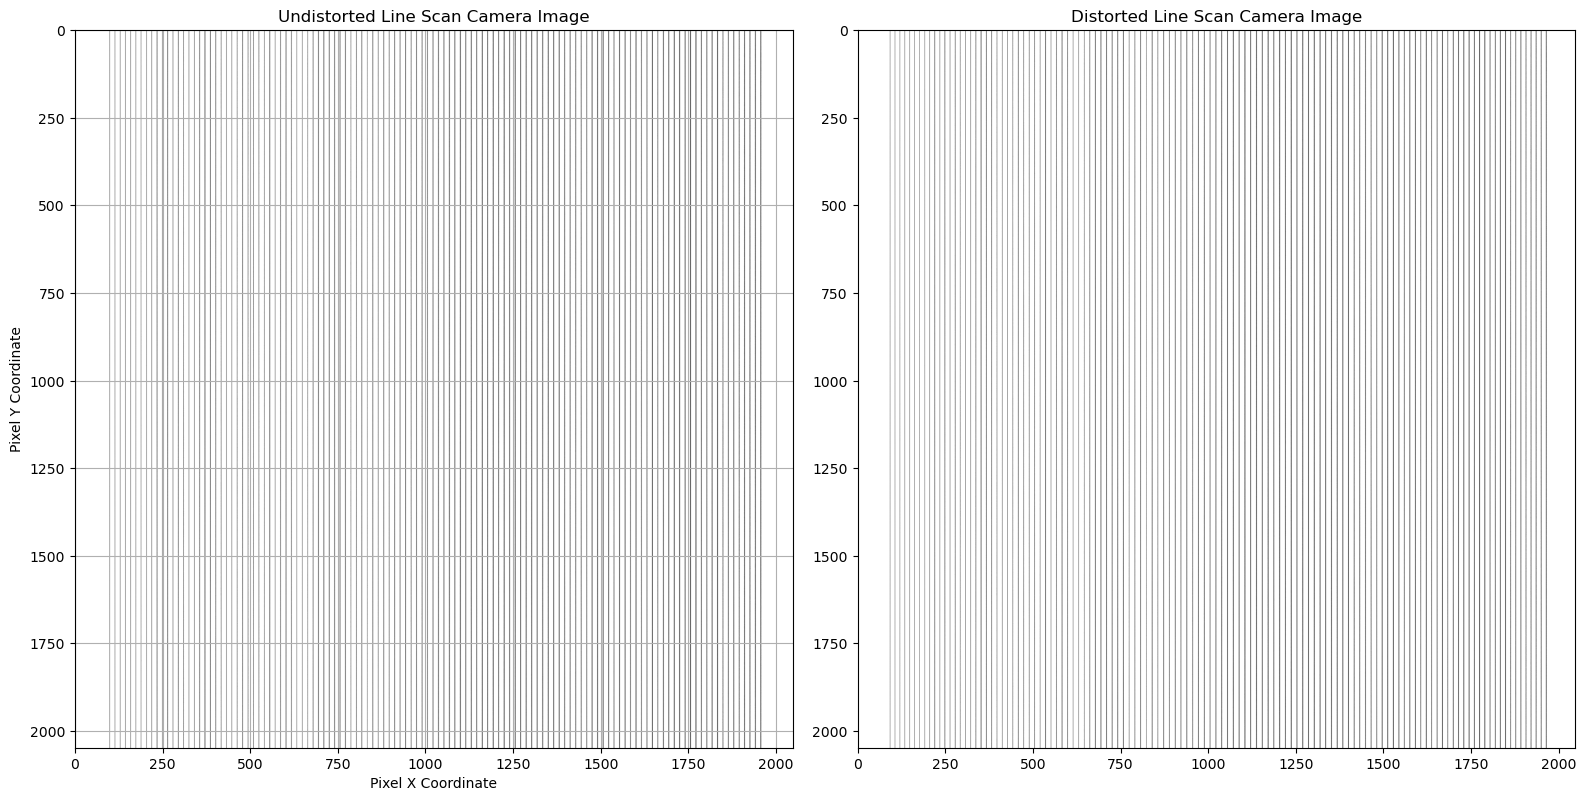

True

In [125]:
image_0
fx = optimized_params['fx']
u0 = optimized_params['u0']
v0 = optimized_params['u0']
k1 = -optimized_params['k1'] 
k2 = -optimized_params['k2']
k3 = -optimized_params['k3']

print(f"k1 = {k1} , k2 = {k2} , k3 = {k3}")

Dist_image = image_0

undistorted_image = remove_distortion_from_real_image(Dist_image, u0, k1, k2, k3, fx)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
# Plot the first set of points
axes[0].imshow(undistorted_image, cmap='gray')
axes[0].set_title('Undistorted Line Scan Camera Image')
axes[0].set_xlabel('Pixel X Coordinate')
axes[0].set_ylabel('Pixel Y Coordinate')
axes[0].grid(True)

# Plot the second set of points
axes[1].imshow(Dist_image, cmap='gray')
axes[1].set_title("Distorted Line Scan Camera Image")
axes[0].set_xlabel('Pixel X Coordinate')
axes[0].set_ylabel('Pixel Y Coordinate')
axes[0].grid(True)

plt.tight_layout()
plt.show()

# Crop the desired region of interest (ROI)
#cropped_roi = undistorted_image[:, 100:2048-100]

# Resize the cropped ROI back to 2048x2048
#undistorted_image = cv2.resize(cropped_roi, (2048, 2048))

# plt.figure(figsize=(8, 6))
# plt.imshow(undistorted_image, cmap='gray')
# plt.title('Undistorted and Scaled Line Scan Image (OpenCV Remap)')
# plt.xlabel('Pixel X Coordinate (u)')
# plt.ylabel('Pixel Y Coordinate (v)')
# plt.show()
cv2.imwrite('road_anomaly_detector/main/calibration/Camera_calibration/workspace/undistorted_image.jpg', undistorted_image)

In [121]:
x_lines_dist = find_line_x(Dist_image,160)
x_lines_nodist = find_line_x(undistorted_image,160)

#plot_cross_dot(image_0,x_lines_dist)
#plot_cross_dot(undistorted_image,x_lines_nodist)

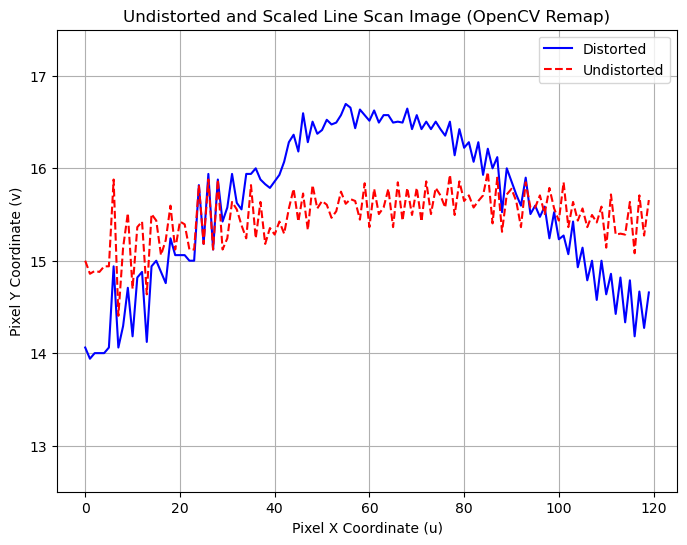

In [122]:
n = len(x_lines_nodist)
distances_undist = np.diff(x_lines_nodist) if n > 1 else np.array([])

n = len(x_lines_dist)
distances_dist = np.diff(x_lines_dist) if n > 1 else np.array([])

plt.figure(figsize=(8, 6))
plt.plot(distances_dist, label='Distorted', color='blue', linestyle='-')
plt.plot(distances_undist, label='Undistorted', color='red', linestyle='--')
plt.title('Undistorted and Scaled Line Scan Image (OpenCV Remap)')
plt.xlabel('Pixel X Coordinate (u)')
plt.ylabel('Pixel Y Coordinate (v)')
plt.ylim(12.5, 17.5)  # Replace 0 and 10 with the desired y-range
plt.legend()  # Add a legend to distinguish between the lines
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()

In [123]:
print(distances_dist*0.8111764705882352)
print(distances_undist*0.8111764705882352)

[11.4056328  11.30730838 11.35647059 11.35647059 11.35647059 11.4056328
 12.11848485 11.4056328  11.59408794 11.93002971 11.50395722 12.02016043
 12.06932264 11.45479501 12.11848485 12.16764706 12.06932264 11.97099822
 12.3642959  12.21680927 12.21680927 12.21680927 12.16764706 12.16764706
 12.8313369  12.31513369 12.92966132 12.26597148 12.88049911 12.51178253
 12.63468806 12.92966132 12.67565657 12.61830065 12.92966132 12.92966132
 12.97882353 12.88049911 12.8395306  12.80675579 12.86411171 12.92146762
 13.03617944 13.20824718 13.27379679 13.12631016 13.46225193 13.20824718
 13.38850862 13.28199049 13.3147653  13.40489602 13.36392751 13.38031491
 13.44586453 13.54418895 13.51141414 13.3311527  13.49502674 13.44586453
 13.39670232 13.48683304 13.38031491 13.44586453 13.44586453 13.38031491
 13.38850862 13.38031491 13.50322044 13.322959   13.44586453 13.322959
 13.38850862 13.322959   13.38850862 13.322959   13.26560309 13.38850862
 13.09353535 13.322959   13.15908497 13.20824718 13.03

# Manual distortion correction

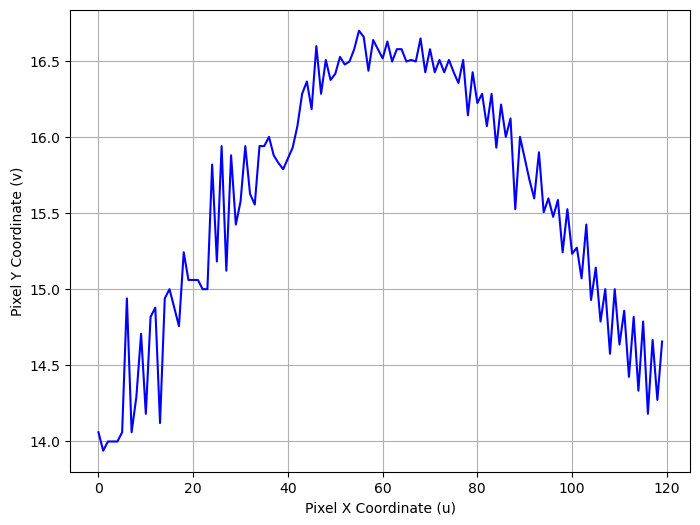

In [48]:
x_lines = find_line_x(image_0,160)
n = len(x_lines)
distances = np.diff(x_lines) if n > 1 else np.array([])

plt.figure(figsize=(8, 6))
plt.plot(distances, label='Distorted', color='blue', linestyle='-')
plt.xlabel('Pixel X Coordinate (u)')
plt.ylabel('Pixel Y Coordinate (v)')
plt.grid(True)  # Optional: Add a grid for better readability
plt.show()